In [2]:
import numpy as np
# import numpy
# import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.model_selection import train_test_split
from DMC.DMC_class import *
from sklearn.model_selection import RepeatedKFold

from sklearn.model_selection import PredefinedSplit, GridSearchCV
import warnings 
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
def add_label_noise(labels, noise_level=0.1, num_classes=3):
    # labels为原始标签数组
    # noise_level为噪声比例
    # num_classes为类别总数
    n_samples = len(labels)
    n_noisy = int(noise_level * n_samples)
    noisy_indices = np.random.choice(n_samples, n_noisy, replace=False)
    for idx in noisy_indices:
        original_label = labels[idx]
        # 从除原标签外的标签中随机选择一个
        possible_labels = list(range(num_classes))
        possible_labels.remove(original_label)
        new_label = np.random.choice(possible_labels)
        labels[idx] = new_label
    return labels

# IRIS

In [174]:
K = 3
L = np.ones((K,K)) - np.eye(K)
n_splits = 10
n_repeats = 10

iris = datasets.load_iris()
X = iris.data
y = iris.target

pi = compute_pi(y,K)

rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)
param_grid = {
        'T': np.arange(5, 25, 1, dtype=int)
    }
dmc = DMC(discretization='kmeans')
grid0 = GridSearchCV(dmc, param_grid, cv=rkf, verbose=3)
grid0.fit(X, y, pi=pi)
T_optimal_kmeans = grid0.best_params_['T']

param_grid = {
        'm': np.arange(1.01, 1.8, 0.05, dtype=float)
    }
dmc = DMC(T=T_optimal_kmeans, discretization='kcmeans', init=grid0.best_estimator_.cntr)
grid1 = GridSearchCV(dmc, param_grid, cv=rkf, verbose=3)
grid1.fit(X, y, pi=pi)
m_optimal_cmeans = grid1.best_params_['m']

Fitting 100 folds for each of 20 candidates, totalling 2000 fits
[CV 1/100] END .............................T=5;, score=0.933 total time=   0.0s
[CV 2/100] END .............................T=5;, score=1.000 total time=   0.0s
[CV 3/100] END .............................T=5;, score=0.867 total time=   0.0s
[CV 4/100] END .............................T=5;, score=0.733 total time=   0.0s
[CV 5/100] END .............................T=5;, score=0.667 total time=   0.0s
[CV 6/100] END .............................T=5;, score=0.733 total time=   0.0s
[CV 7/100] END .............................T=5;, score=0.867 total time=   0.0s
[CV 8/100] END .............................T=5;, score=0.800 total time=   0.0s
[CV 9/100] END .............................T=5;, score=0.933 total time=   0.0s
[CV 10/100] END ............................T=5;, score=1.000 total time=   0.0s
[CV 11/100] END ............................T=5;, score=0.933 total time=   0.0s
[CV 12/100] END ............................

KeyboardInterrupt: 

In [90]:
grid1.cv_results_

{'mean_fit_time': array([0.11175477, 0.11161731, 0.11139376, 0.11194865, 0.11141192,
        0.07031478, 0.04936733, 0.04942238, 0.04938347, 0.05057055,
        0.05085037, 0.0504737 , 0.04924059, 0.05058912, 0.05044168,
        0.05049351]),
 'std_fit_time': array([0.00115564, 0.00504562, 0.00113076, 0.00457994, 0.00132496,
        0.02905739, 0.00464481, 0.00357301, 0.00458551, 0.00520292,
        0.00470175, 0.00509126, 0.00386057, 0.00534433, 0.00537869,
        0.00434795]),
 'mean_score_time': array([0.00134052, 0.001255  , 0.00124865, 0.00125186, 0.00121581,
        0.00099466, 0.00075301, 0.00078881, 0.00077649, 0.00083239,
        0.00071277, 0.00080877, 0.00080965, 0.0008289 , 0.00070081,
        0.00079347]),
 'std_score_time': array([0.0004818 , 0.00047512, 0.00043385, 0.00039457, 0.00048004,
        0.00056426, 0.00045709, 0.00049224, 0.00044085, 0.00047118,
        0.00055515, 0.00042791, 0.00044384, 0.00042046, 0.00049021,
        0.00045359]),
 'param_m': masked_array(d

In [175]:
T = 15
m = 1.3

K = 3
L = np.ones((K,K)) - np.eye(K)

iris = datasets.load_iris()
X = iris.data
y = iris.target

n_splits = 5
n_repeats = 20

# 设置交叉验证
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)
acc_kmeans_label_noise = np.zeros((6, n_splits * n_repeats))
acc_kcmeans_label_noise = np.zeros((6, n_splits * n_repeats))
noise_level = 0.0

for i in range(6):
    
    iteration = 0
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        y_train = add_label_noise(y_train, noise_level=noise_level, num_classes=K)
        
        kmeans = DMC(T=T, discretization='kmeans')
        kmeans.fit(X_train, y_train)
        
        kcmeans = DMC(T=T, m=m, discretization='kcmeans', init=kmeans.cntr)
        kcmeans.fit(X_train, y_train)
    
        y_pred_kmeans = kmeans.predict(X_test, pi=kmeans.piTrain)
        y_pred_kcmeans = kcmeans.predict(X_test, pi=kcmeans.piTrain)
    
        acc_kmeans_label_noise[i, iteration] = accuracy_score(y_test, y_pred_kmeans)
        acc_kcmeans_label_noise[i, iteration] = accuracy_score(y_test, y_pred_kcmeans)
    
        iteration += 1
    
    noise_level += 0.05

In [176]:
from scipy.stats import wilcoxon

# 比较每个噪音水平下的两种方法
for i in range(acc_kmeans_label_noise.shape[0]):
    stat, p_value = wilcoxon(acc_kmeans_label_noise[i], acc_kcmeans_label_noise[i])
    print(f"Noise level {i+1} - Wilcoxon test result: statistic={stat}, pvalue={p_value}")

Noise level 1 - Wilcoxon test result: statistic=67.5, pvalue=0.0002227559539530354
Noise level 2 - Wilcoxon test result: statistic=14.5, pvalue=2.7033074086086817e-07
Noise level 3 - Wilcoxon test result: statistic=28.0, pvalue=6.169292118409102e-07
Noise level 4 - Wilcoxon test result: statistic=75.0, pvalue=5.725292737005907e-07
Noise level 5 - Wilcoxon test result: statistic=117.5, pvalue=7.62370107340452e-07
Noise level 6 - Wilcoxon test result: statistic=116.5, pvalue=7.505048720539808e-09


In [177]:
T = 15
m = 1.3

K = 3
L = np.ones((K,K)) - np.eye(K)

iris = datasets.load_iris()
X = iris.data
y = iris.target

std_devs = np.std(X, axis=0)

n_splits = 5
n_repeats = 20
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)

acc_kmeans_noise = np.zeros((6, n_splits * n_repeats))
acc_kcmeans_noise = np.zeros((6, n_splits * n_repeats))

noise_level = 0.0
for i in range(6): 
    iteration = 0
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        noise_levels = noise_level * std_devs
        noise = np.random.normal(0, noise_levels, X_test.shape)
        X_test = X_test + noise
        
        kmeans = DMC(T=T, discretization='kmeans')
        kmeans.fit(X_train, y_train)
        
        kcmeans = DMC(T=T, m=m, discretization='kcmeans', init=kmeans.cntr)
        kcmeans.fit(X_train, y_train)
    
        y_pred_kmeans = kmeans.predict(X_test, pi=kmeans.piTrain)
        y_pred_kcmeans = kcmeans.predict(X_test, pi=kmeans.piTrain)
    
        acc_kmeans_noise[i, iteration] = accuracy_score(y_test, y_pred_kmeans)
        acc_kcmeans_noise[i, iteration] = accuracy_score(y_test, y_pred_kcmeans)
    
        iteration += 1
    noise_level += 0.1

In [178]:
from scipy.stats import wilcoxon

# 比较每个噪音水平下的两种方法
for i in range(acc_kmeans_noise.shape[0]):
    stat, p_value = wilcoxon(acc_kmeans_noise[i], acc_kcmeans_noise[i])
    print(f"Noise level {i+1} - Wilcoxon test result: statistic={stat}, pvalue={p_value}")

Noise level 1 - Wilcoxon test result: statistic=0.0, pvalue=7.450682457680531e-08
Noise level 2 - Wilcoxon test result: statistic=277.0, pvalue=0.033330965644508506
Noise level 3 - Wilcoxon test result: statistic=165.5, pvalue=0.053488617612041024
Noise level 4 - Wilcoxon test result: statistic=315.0, pvalue=0.07459553610171588
Noise level 5 - Wilcoxon test result: statistic=585.0, pvalue=0.04557387238111739
Noise level 6 - Wilcoxon test result: statistic=522.0, pvalue=0.04931673606212873


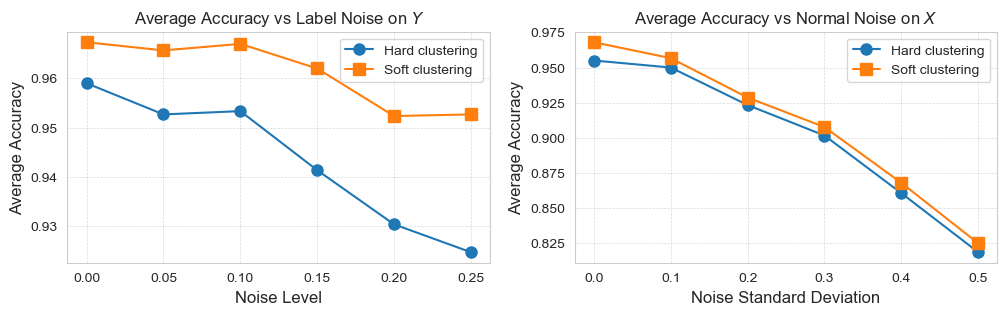

In [179]:
fig, ax = plt.subplots(1,2, figsize=(12,3))

kmeans_means_noise = np.mean(acc_kmeans_noise, axis=1)
kcmeans_means_noise = np.mean(acc_kcmeans_noise, axis=1)

kmeans_means_label_noise = np.mean(acc_kmeans_label_noise, axis=1)
kcmeans_means_label_noise = np.mean(acc_kcmeans_label_noise, axis=1)

# 创建噪声级别数组
noise_levels = np.linspace(0.0, 0.25, 6)

# 绘制点，无线条，添加标记
ax[0].plot(noise_levels, kmeans_means_label_noise, 'o-', label='Hard clustering', markersize=8)  # 'o-' 是圆形标记
ax[0].plot(noise_levels, kcmeans_means_label_noise, 's-', label='Soft clustering', markersize=8)  # 's-' 是方形标记

# 设置图表标题和轴标签
ax[0].set_title('Average Accuracy vs Label Noise on $Y$', fontsize=12)
ax[0].set_xlabel('Noise Level', fontsize=12)
ax[0].set_ylabel('Average Accuracy', fontsize=12)

# 添加图例
ax[0].legend()

noise_std = np.linspace(0.0, 0.5, 6)

# 绘制点，无线条，添加标记
ax[1].plot(noise_std, kmeans_means_noise, 'o-', label='Hard clustering', markersize=8)  # 'o-' 是圆形标记
ax[1].plot(noise_std, kcmeans_means_noise, 's-', label='Soft clustering', markersize=8)  # 's-' 是方形标记

# 设置图表标题和轴标签
ax[1].set_title('Average Accuracy vs Normal Noise on $X$', fontsize=12)
ax[1].set_xlabel('Noise Standard Deviation', fontsize=12)
ax[1].set_ylabel('Average Accuracy', fontsize=12)

# 添加图例
ax[1].legend()

xticks_to_display = noise_levels[::1]  # 这里选择了每隔一个显示
ax[0].set_xticks(xticks_to_display)

xticks_to_display = noise_std[::1]
ax[1].set_xticks(xticks_to_display)
ax[0].grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.3)
ax[1].grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.3)

fig.savefig(f'../image/IRIS_vs_Noise.pdf', bbox_inches='tight')

# Breast cancer

In [142]:
K = 2
L = np.ones((K,K)) - np.eye(K)

n_splits = 10
n_repeats = 10

breast = datasets.load_breast_cancer()
X = breast.data
y = breast.target


rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)
param_grid = {
        'T': np.arange(5, 25, 1, dtype=int)
    }
dmc = DMC(discretization='kmeans')
grid0 = GridSearchCV(dmc, param_grid, cv=rkf, verbose=3)
grid0.fit(X, y)
T_optimal_kmeans = grid0.best_params_['T']

param_grid = {
        'm': np.arange(1.01, 1.8, 0.05, dtype=float)
    }
dmc = DMC(T=T_optimal_kmeans, discretization='kcmeans', init=grid0.best_estimator_.cntr)
grid1 = GridSearchCV(dmc, param_grid, cv=rkf, verbose=3)
grid1.fit(X, y)
m_optimal_cmeans = grid1.best_params_['m']

Fitting 100 folds for each of 20 candidates, totalling 2000 fits
[CV 1/100] END .............................T=5;, score=0.877 total time=   0.0s
[CV 2/100] END .............................T=5;, score=0.825 total time=   0.0s
[CV 3/100] END .............................T=5;, score=0.807 total time=   0.0s
[CV 4/100] END .............................T=5;, score=0.930 total time=   0.0s
[CV 5/100] END .............................T=5;, score=0.930 total time=   0.0s
[CV 6/100] END .............................T=5;, score=0.860 total time=   0.0s
[CV 7/100] END .............................T=5;, score=0.842 total time=   0.0s
[CV 8/100] END .............................T=5;, score=0.930 total time=   0.0s
[CV 9/100] END .............................T=5;, score=0.877 total time=   0.0s
[CV 10/100] END ............................T=5;, score=0.804 total time=   0.0s
[CV 11/100] END ............................T=5;, score=0.842 total time=   0.0s
[CV 12/100] END ............................

In [145]:
grid1.cv_results_

{'mean_fit_time': array([0.0548777 , 0.05388718, 0.05318028, 0.05368081, 0.05431621,
        0.05443851, 0.05524779, 0.05337169, 0.05738664, 0.0916989 ,
        0.11831873, 0.11812524, 0.11825772, 0.06517926, 0.05523988,
        0.05368385]),
 'std_fit_time': array([0.00605256, 0.00558372, 0.00497753, 0.00610637, 0.00541818,
        0.00602232, 0.00590728, 0.00467446, 0.00585667, 0.03166266,
        0.00294143, 0.00231759, 0.0061949 , 0.02253673, 0.00563804,
        0.00520474]),
 'mean_score_time': array([0.00114976, 0.00096696, 0.00094524, 0.00096565, 0.00103328,
        0.00101204, 0.00098019, 0.00090745, 0.00113755, 0.00143306,
        0.00158973, 0.00149755, 0.00152379, 0.00105292, 0.00100187,
        0.00098593]),
 'std_score_time': array([0.00043784, 0.00048902, 0.00043345, 0.00038771, 0.00046904,
        0.00039363, 0.00038662, 0.00037438, 0.00039595, 0.00061191,
        0.00051155, 0.00050309, 0.00052442, 0.00045589, 0.0004215 ,
        0.00048166]),
 'param_m': masked_array(d

In [180]:
T = 15
m = 1.5
K = 2
L = np.ones((K,K)) - np.eye(K)

n_splits = 5
n_repeats = 20

breast = datasets.load_breast_cancer()
X = breast.data
y = breast.target

# 设置交叉验证
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)
acc_kmeans_label_noise = np.zeros((6, n_splits * n_repeats))
acc_kcmeans_label_noise = np.zeros((6, n_splits * n_repeats))
noise_level = 0.0

for i in range(6):
    iteration = 0
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        y_train = add_label_noise(y_train, noise_level=noise_level, num_classes=K)
        
        kmeans = DMC(T=T, discretization='kmeans')
        kmeans.fit(X_train, y_train)
        
        kcmeans = DMC(T=T, m=m, discretization='kcmeans', init=kmeans.cntr)
        kcmeans.fit(X_train, y_train)
    
        y_pred_kmeans = kmeans.predict(X_test, pi=kmeans.piTrain)
        y_pred_kcmeans = kcmeans.predict(X_test, pi=kcmeans.piTrain)
        
        # y_pred_kmeans = kmeans.predict(X_test, pi=kmeans.piStar)
        # y_pred_kcmeans = kcmeans.predict(X_test, pi=kcmeans.piStar)
    
        acc_kmeans_label_noise[i, iteration] = accuracy_score(y_test, y_pred_kmeans)
        acc_kcmeans_label_noise[i, iteration] = accuracy_score(y_test, y_pred_kcmeans)
    
        iteration += 1
    
    noise_level += 0.05

In [181]:
from scipy.stats import wilcoxon

# 比较每个噪音水平下的两种方法
for i in range(acc_kmeans_label_noise.shape[0]):
    stat, p_value = wilcoxon(acc_kmeans_label_noise[i], acc_kcmeans_label_noise[i])
    print(f"Noise level {i+1} - Wilcoxon test result: statistic={stat}, pvalue={p_value}")

Noise level 1 - Wilcoxon test result: statistic=306.0, pvalue=0.48907536120191786
Noise level 2 - Wilcoxon test result: statistic=366.5, pvalue=0.7412359180533427
Noise level 3 - Wilcoxon test result: statistic=323.5, pvalue=0.1632249338030246
Noise level 4 - Wilcoxon test result: statistic=326.0, pvalue=0.1116924412956414
Noise level 5 - Wilcoxon test result: statistic=297.5, pvalue=0.0026774218648545818
Noise level 6 - Wilcoxon test result: statistic=343.5, pvalue=0.0001887129487551769


In [185]:
T = 15
m = 1.5

K = 2
L = np.ones((K,K)) - np.eye(K)

breast = datasets.load_breast_cancer()
X = breast.data
y = breast.target

std_devs = np.std(X, axis=0)

n_splits = 5
n_repeats = 20
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)

acc_kmeans_noise = np.zeros((6, n_splits * n_repeats))
acc_kcmeans_noise = np.zeros((6, n_splits * n_repeats))

noise_level = 0.0
for i in range(6): 
    iteration = 0
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        noise_levels = noise_level * std_devs
        noise = np.random.normal(0, noise_levels, X_test.shape)
        X_test = X_test + noise
        
        kmeans = DMC(T=T, discretization='kmeans')
        kmeans.fit(X_train, y_train)
        
        kcmeans = DMC(T=T, m=m, discretization='kcmeans', init=kmeans.cntr)
        kcmeans.fit(X_train, y_train)
    
        y_pred_kmeans = kmeans.predict(X_test, pi=kmeans.piTrain)
        y_pred_kcmeans = kcmeans.predict(X_test, pi=kcmeans.piTrain)
    
        acc_kmeans_noise[i, iteration] = accuracy_score(y_test, y_pred_kmeans)
        acc_kcmeans_noise[i, iteration] = accuracy_score(y_test, y_pred_kcmeans)
    
        iteration += 1
    noise_level += 0.1

In [183]:
from scipy.stats import wilcoxon

# 比较每个噪音水平下的两种方法
for i in range(acc_kmeans_noise.shape[0]):
    stat, p_value = wilcoxon(acc_kmeans_noise[i], acc_kcmeans_noise[i])
    print(f"Noise level {i+1} - Wilcoxon test result: statistic={stat}, pvalue={p_value}")

Noise level 1 - Wilcoxon test result: statistic=305.0, pvalue=0.06611934759242369
Noise level 2 - Wilcoxon test result: statistic=401.5, pvalue=0.9076131191930494
Noise level 3 - Wilcoxon test result: statistic=452.0, pvalue=0.6127424663050094
Noise level 4 - Wilcoxon test result: statistic=822.0, pvalue=0.7936498101237801
Noise level 5 - Wilcoxon test result: statistic=999.0, pvalue=0.3792282360036294
Noise level 6 - Wilcoxon test result: statistic=874.5, pvalue=0.003518413894813632


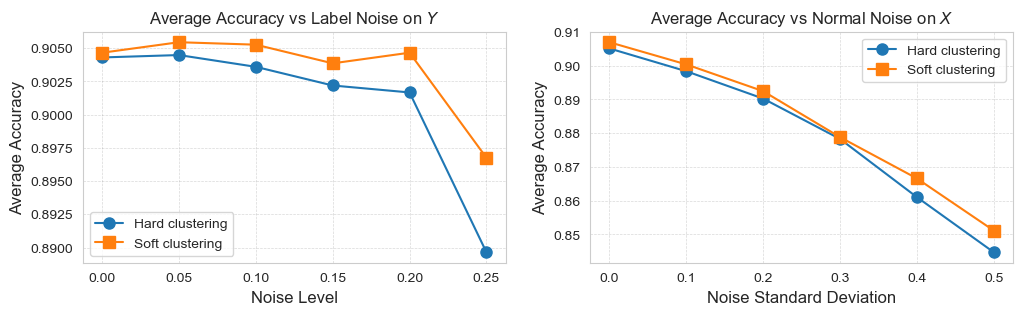

In [186]:
fig, ax = plt.subplots(1,2, figsize=(12,3))

kmeans_means_noise = np.mean(acc_kmeans_noise, axis=1)
kcmeans_means_noise = np.mean(acc_kcmeans_noise, axis=1)

kmeans_means_label_noise = np.mean(acc_kmeans_label_noise, axis=1)
kcmeans_means_label_noise = np.mean(acc_kcmeans_label_noise, axis=1)

# 创建噪声级别数组
noise_levels = np.linspace(0.0, 0.25, 6)

# 绘制点，无线条，添加标记
ax[0].plot(noise_levels, kmeans_means_label_noise, 'o-', label='Hard clustering', markersize=8)  # 'o-' 是圆形标记
ax[0].plot(noise_levels, kcmeans_means_label_noise, 's-', label='Soft clustering', markersize=8)  # 's-' 是方形标记

# 设置图表标题和轴标签
ax[0].set_title('Average Accuracy vs Label Noise on $Y$', fontsize=12)
ax[0].set_xlabel('Noise Level', fontsize=12)
ax[0].set_ylabel('Average Accuracy', fontsize=12)

# 添加图例
ax[0].legend()

noise_std = np.linspace(0.0, 0.5, 6)

# 绘制点，无线条，添加标记
ax[1].plot(noise_std, kmeans_means_noise, 'o-', label='Hard clustering', markersize=8)  # 'o-' 是圆形标记
ax[1].plot(noise_std, kcmeans_means_noise, 's-', label='Soft clustering', markersize=8)  # 's-' 是方形标记

# 设置图表标题和轴标签
ax[1].set_title('Average Accuracy vs Normal Noise on $X$', fontsize=12)
ax[1].set_xlabel('Noise Standard Deviation', fontsize=12)
ax[1].set_ylabel('Average Accuracy', fontsize=12)

# 添加图例
ax[1].legend()

xticks_to_display = noise_levels[::1]  # 这里选择了每隔一个显示
ax[0].set_xticks(xticks_to_display)

xticks_to_display = noise_std[::1]
ax[1].set_xticks(xticks_to_display)
ax[0].grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.3)
ax[1].grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.3)

fig.savefig(f'../image/Breast_Cancer_vs_Noise.pdf', bbox_inches='tight')

# Diabetes

In [187]:
diabetes_df = pd.read_csv('./data/diabetes.csv')
X = diabetes_df.iloc[:,:-1].to_numpy()
y = diabetes_df.iloc[:,-1].to_numpy()

In [132]:
K = 2
L = np.ones((K,K)) - np.eye(K)

n_splits = 10
n_repeats = 10

diabetes_df = pd.read_csv('./data/diabetes.csv')
X = diabetes_df.iloc[:,:-1].to_numpy()
y = diabetes_df.iloc[:,-1].to_numpy()


rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)
param_grid = {
        'T': np.arange(5, 25, 1, dtype=int)
    }
dmc = DMC(discretization='kmeans')
grid0 = GridSearchCV(dmc, param_grid, cv=rkf, verbose=3)
grid0.fit(X, y)
T_optimal_kmeans = grid0.best_params_['T']

param_grid = {
        'm': np.arange(1.01, 1.8, 0.05, dtype=float)
    }
dmc = DMC(T=T_optimal_kmeans, discretization='kcmeans', init=grid0.best_estimator_.cntr)
grid1 = GridSearchCV(dmc, param_grid, cv=rkf, verbose=3)
grid1.fit(X, y)
m_optimal_cmeans = grid1.best_params_['m']

Fitting 100 folds for each of 20 candidates, totalling 2000 fits
[CV 1/100] END .............................T=5;, score=0.675 total time=   0.0s
[CV 2/100] END .............................T=5;, score=0.532 total time=   0.0s
[CV 3/100] END .............................T=5;, score=0.519 total time=   0.0s
[CV 4/100] END .............................T=5;, score=0.662 total time=   0.0s
[CV 5/100] END .............................T=5;, score=0.597 total time=   0.0s
[CV 6/100] END .............................T=5;, score=0.494 total time=   0.0s
[CV 7/100] END .............................T=5;, score=0.675 total time=   0.0s
[CV 8/100] END .............................T=5;, score=0.597 total time=   0.0s
[CV 9/100] END .............................T=5;, score=0.605 total time=   0.0s
[CV 10/100] END ............................T=5;, score=0.539 total time=   0.0s
[CV 11/100] END ............................T=5;, score=0.623 total time=   0.0s
[CV 12/100] END ............................

KeyboardInterrupt: 

In [25]:
grid1.cv_results_

{'mean_fit_time': array([0.10512441, 0.05572762, 0.06527375, 0.12407944, 0.12283095,
        0.12240876, 0.12251847, 0.12227776, 0.1226033 , 0.12231205,
        0.12229316, 0.12290182, 0.12233387, 0.12265576, 0.0788884 ,
        0.07709103]),
 'std_fit_time': array([0.03069226, 0.00317709, 0.02361933, 0.00336615, 0.0030973 ,
        0.00342073, 0.00304194, 0.00312553, 0.00243122, 0.00272355,
        0.00300924, 0.00288086, 0.00287636, 0.00271637, 0.03080154,
        0.03241412]),
 'mean_score_time': array([0.00173381, 0.0011935 , 0.00130735, 0.00200357, 0.00179079,
        0.00184966, 0.00173174, 0.00172536, 0.00170096, 0.00179185,
        0.00186373, 0.00171436, 0.00188987, 0.00186867, 0.00137256,
        0.00135695]),
 'std_score_time': array([0.0005127 , 0.0004389 , 0.00051891, 0.00111225, 0.00041202,
        0.00093624, 0.00045128, 0.00044148, 0.00044906, 0.00048145,
        0.00041424, 0.00043814, 0.00080627, 0.00050955, 0.00057707,
        0.00053925]),
 'param_m': masked_array(d

In [188]:
T = 20
m = 1.3
K = 2
L = np.ones((K,K)) - np.eye(K)

n_splits = 5
n_repeats = 20

X = diabetes_df.iloc[:,:-1].to_numpy()
y = diabetes_df.iloc[:,-1].to_numpy()

# 设置交叉验证
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)
acc_kmeans_label_noise = np.zeros((6, n_splits * n_repeats))
acc_kcmeans_label_noise = np.zeros((6, n_splits * n_repeats))
noise_level = 0.0

for i in range(6):
    iteration = 0
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        y_train = add_label_noise(y_train, noise_level=noise_level, num_classes=K)
        
        kmeans = DMC(T=T, discretization='kmeans')
        kmeans.fit(X_train, y_train)
        
        kcmeans = DMC(T=T, m=m, discretization='kcmeans', init=kmeans.cntr)
        kcmeans.fit(X_train, y_train)
    
        y_pred_kmeans = kmeans.predict(X_test, pi=kmeans.piTrain)
        y_pred_kcmeans = kcmeans.predict(X_test, pi=kcmeans.piTrain)
        
        # y_pred_kmeans = kmeans.predict(X_test, pi=kmeans.piStar)
        # y_pred_kcmeans = kcmeans.predict(X_test, pi=kcmeans.piStar)
    
        acc_kmeans_label_noise[i, iteration] = accuracy_score(y_test, y_pred_kmeans)
        acc_kcmeans_label_noise[i, iteration] = accuracy_score(y_test, y_pred_kcmeans)
    
        iteration += 1
    
    noise_level += 0.05

In [193]:
T = 20
m = 1.3

K = 2
L = np.ones((K,K)) - np.eye(K)

X = diabetes_df.iloc[:,:-1].to_numpy()
y = diabetes_df.iloc[:,-1].to_numpy()

std_devs = np.std(X, axis=0)

n_splits = 5
n_repeats = 20
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)

acc_kmeans_noise = np.zeros((6, n_splits * n_repeats))
acc_kcmeans_noise = np.zeros((6, n_splits * n_repeats))

noise_level = 0.0
for i in range(6): 
    iteration = 0
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        noise_levels = noise_level * std_devs
        noise = np.random.normal(0, noise_levels, X_test.shape)
        X_test = X_test + noise
        
        kmeans = DMC(T=T, discretization='kmeans')
        kmeans.fit(X_train, y_train)
        
        kcmeans = DMC(T=T, m=m, discretization='kcmeans', init=kmeans.cntr)
        kcmeans.fit(X_train, y_train)
    
        y_pred_kmeans = kmeans.predict(X_test, pi=kmeans.piTrain)
        y_pred_kcmeans = kcmeans.predict(X_test, pi=kcmeans.piTrain)
    
        acc_kmeans_noise[i, iteration] = accuracy_score(y_test, y_pred_kmeans)
        acc_kcmeans_noise[i, iteration] = accuracy_score(y_test, y_pred_kcmeans)
    
        iteration += 1
    noise_level += 0.1

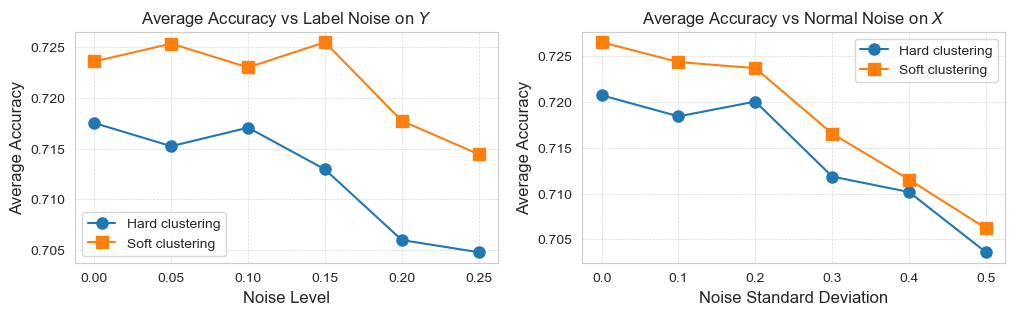

In [194]:
fig, ax = plt.subplots(1,2, figsize=(12,3))

kmeans_means_noise = np.mean(acc_kmeans_noise, axis=1)
kcmeans_means_noise = np.mean(acc_kcmeans_noise, axis=1)

kmeans_means_label_noise = np.mean(acc_kmeans_label_noise, axis=1)
kcmeans_means_label_noise = np.mean(acc_kcmeans_label_noise, axis=1)

# 创建噪声级别数组
noise_levels = np.linspace(0.0, 0.25, 6)

# 绘制点，无线条，添加标记
ax[0].plot(noise_levels, kmeans_means_label_noise, 'o-', label='Hard clustering', markersize=8)  # 'o-' 是圆形标记
ax[0].plot(noise_levels, kcmeans_means_label_noise, 's-', label='Soft clustering', markersize=8)  # 's-' 是方形标记

# 设置图表标题和轴标签
ax[0].set_title('Average Accuracy vs Label Noise on $Y$', fontsize=12)
ax[0].set_xlabel('Noise Level', fontsize=12)
ax[0].set_ylabel('Average Accuracy', fontsize=12)

# 添加图例
ax[0].legend()

noise_std = np.linspace(0.0, 0.5, 6)

# 绘制点，无线条，添加标记
ax[1].plot(noise_std, kmeans_means_noise, 'o-', label='Hard clustering', markersize=8)  # 'o-' 是圆形标记
ax[1].plot(noise_std, kcmeans_means_noise, 's-', label='Soft clustering', markersize=8)  # 's-' 是方形标记

# 设置图表标题和轴标签
ax[1].set_title('Average Accuracy vs Normal Noise on $X$', fontsize=12)
ax[1].set_xlabel('Noise Standard Deviation', fontsize=12)
ax[1].set_ylabel('Average Accuracy', fontsize=12)

# 添加图例
ax[1].legend()

xticks_to_display = noise_levels[::1]  # 这里选择了每隔一个显示
ax[0].set_xticks(xticks_to_display)

xticks_to_display = noise_std[::1]
ax[1].set_xticks(xticks_to_display)
ax[0].grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.3)
ax[1].grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.3)

fig.savefig(f'../image/Diabetes_vs_Noise.pdf', bbox_inches='tight')

# Heart Disease

In [195]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
# data (as pandas dataframes) 
X = heart_disease.data.features.to_numpy()
y = heart_disease.data.targets.to_numpy()
y[y > 0] = 1

mask = ~np.isnan(X).any(axis=1)
X = X[mask]
y = y[mask]

In [61]:
K = 2
L = np.ones((K,K)) - np.eye(K)

n_splits = 10
n_repeats = 10

rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)
param_grid = {
        'T': np.arange(5, 25, 1, dtype=int)
    }
dmc = DMC(discretization='kmeans')
grid0 = GridSearchCV(dmc, param_grid, cv=rkf, verbose=3)
grid0.fit(X, y)
T_optimal_kmeans = grid0.best_params_['T']
# 
# param_grid = {
#         'm': np.arange(1.01, 1.8, 0.05, dtype=float)
#     }
# dmc = DMC(T=T_optimal_kmeans, discretization='kcmeans', init=grid0.best_estimator_.cntr)
# grid1 = GridSearchCV(dmc, param_grid, cv=rkf, verbose=3)
# grid1.fit(X, y)
# m_optimal_cmeans = grid1.best_params_['m']

Fitting 100 folds for each of 20 candidates, totalling 2000 fits
[CV 1/100] END .............................T=5;, score=0.600 total time=   0.0s
[CV 2/100] END .............................T=5;, score=0.600 total time=   0.0s
[CV 3/100] END .............................T=5;, score=0.733 total time=   0.0s
[CV 4/100] END .............................T=5;, score=0.600 total time=   0.0s
[CV 5/100] END .............................T=5;, score=0.467 total time=   0.0s
[CV 6/100] END .............................T=5;, score=0.700 total time=   0.0s
[CV 7/100] END .............................T=5;, score=0.633 total time=   0.0s
[CV 8/100] END .............................T=5;, score=0.690 total time=   0.0s
[CV 9/100] END .............................T=5;, score=0.690 total time=   0.0s
[CV 10/100] END ............................T=5;, score=0.690 total time=   0.0s
[CV 11/100] END ............................T=5;, score=0.633 total time=   0.0s
[CV 12/100] END ............................

In [62]:
grid0.cv_results_

{'mean_fit_time': array([0.04738881, 0.05000765, 0.05221341, 0.05251385, 0.05146325,
        0.051351  , 0.04999965, 0.05415832, 0.05712857, 0.0548595 ,
        0.05523322, 0.0611568 , 0.05405568, 0.05556447, 0.05543424,
        0.05509811, 0.05492715, 0.05579634, 0.05657598, 0.05457759]),
 'std_fit_time': array([0.00488971, 0.00583026, 0.00672271, 0.00725824, 0.00446553,
        0.00346183, 0.00372345, 0.00835744, 0.00910343, 0.00499159,
        0.00625084, 0.01150008, 0.00405383, 0.0051649 , 0.0058101 ,
        0.0052952 , 0.0057037 , 0.00483521, 0.00634776, 0.00453713]),
 'mean_score_time': array([0.00296223, 0.00303672, 0.00312245, 0.0030115 , 0.00313136,
        0.00312164, 0.00308034, 0.00315651, 0.0032284 , 0.00324624,
        0.00320666, 0.0032237 , 0.00315876, 0.00318968, 0.00324822,
        0.0031715 , 0.00313047, 0.0031094 , 0.00314792, 0.00316971]),
 'std_score_time': array([0.0003979 , 0.00037569, 0.00051408, 0.00027396, 0.00032903,
        0.00040726, 0.00036456, 0.000404

In [196]:
T = 20
m = 1.3
K = 2
L = np.ones((K,K)) - np.eye(K)

n_splits = 5
n_repeats = 20


# 设置交叉验证
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)
acc_kmeans_label_noise = np.zeros((6, n_splits * n_repeats))
acc_kcmeans_label_noise = np.zeros((6, n_splits * n_repeats))
noise_level = 0.0

for i in range(6):
    iteration = 0
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        y_train = add_label_noise(y_train, noise_level=noise_level, num_classes=K)
        
        kmeans = DMC(T=T, discretization='kmeans')
        kmeans.fit(X_train, y_train)
        
        kcmeans = DMC(T=T, m=m, discretization='kcmeans', init=kmeans.cntr)
        kcmeans.fit(X_train, y_train)
    
        y_pred_kmeans = kmeans.predict(X_test, pi=kmeans.piTrain)
        y_pred_kcmeans = kcmeans.predict(X_test, pi=kcmeans.piTrain)
        
        # y_pred_kmeans = kmeans.predict(X_test, pi=kmeans.piStar)
        # y_pred_kcmeans = kcmeans.predict(X_test, pi=kcmeans.piStar)
    
        acc_kmeans_label_noise[i, iteration] = accuracy_score(y_test, y_pred_kmeans)
        acc_kcmeans_label_noise[i, iteration] = accuracy_score(y_test, y_pred_kcmeans)
    
        iteration += 1
    
    noise_level += 0.05

In [197]:
T = 20
m = 1.3

K = 2
L = np.ones((K,K)) - np.eye(K)

std_devs = np.std(X, axis=0)

n_splits = 5
n_repeats = 20
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)

acc_kmeans_noise = np.zeros((6, n_splits * n_repeats))
acc_kcmeans_noise = np.zeros((6, n_splits * n_repeats))

noise_level = 0.0
for i in range(6): 
    iteration = 0
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        noise_levels = noise_level * std_devs
        noise = np.random.normal(0, noise_levels, X_test.shape)
        X_test = X_test + noise
        
        kmeans = DMC(T=T, discretization='kmeans')
        kmeans.fit(X_train, y_train)
        
        kcmeans = DMC(T=T, m=m, discretization='kcmeans', init=kmeans.cntr)
        kcmeans.fit(X_train, y_train)
    
        y_pred_kmeans = kmeans.predict(X_test, pi=kmeans.piTrain)
        y_pred_kcmeans = kcmeans.predict(X_test, pi=kcmeans.piTrain)
    
        acc_kmeans_noise[i, iteration] = accuracy_score(y_test, y_pred_kmeans)
        acc_kcmeans_noise[i, iteration] = accuracy_score(y_test, y_pred_kcmeans)
    
        iteration += 1
    noise_level += 0.1

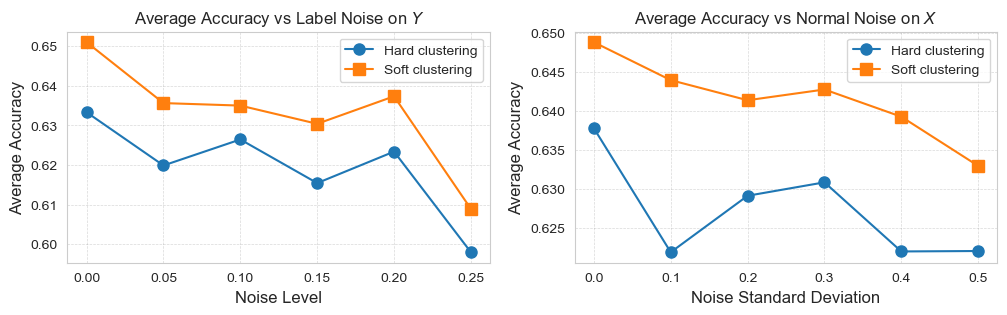

In [198]:
fig, ax = plt.subplots(1,2, figsize=(12,3))

kmeans_means_noise = np.mean(acc_kmeans_noise, axis=1)
kcmeans_means_noise = np.mean(acc_kcmeans_noise, axis=1)

kmeans_means_label_noise = np.mean(acc_kmeans_label_noise, axis=1)
kcmeans_means_label_noise = np.mean(acc_kcmeans_label_noise, axis=1)

# 创建噪声级别数组
noise_levels = np.linspace(0.0, 0.25, 6)

# 绘制点，无线条，添加标记
ax[0].plot(noise_levels, kmeans_means_label_noise, 'o-', label='Hard clustering', markersize=8)  # 'o-' 是圆形标记
ax[0].plot(noise_levels, kcmeans_means_label_noise, 's-', label='Soft clustering', markersize=8)  # 's-' 是方形标记

# 设置图表标题和轴标签
ax[0].set_title('Average Accuracy vs Label Noise on $Y$', fontsize=12)
ax[0].set_xlabel('Noise Level', fontsize=12)
ax[0].set_ylabel('Average Accuracy', fontsize=12)

# 添加图例
ax[0].legend()

noise_std = np.linspace(0.0, 0.5, 6)

# 绘制点，无线条，添加标记
ax[1].plot(noise_std, kmeans_means_noise, 'o-', label='Hard clustering', markersize=8)  # 'o-' 是圆形标记
ax[1].plot(noise_std, kcmeans_means_noise, 's-', label='Soft clustering', markersize=8)  # 's-' 是方形标记

# 设置图表标题和轴标签
ax[1].set_title('Average Accuracy vs Normal Noise on $X$', fontsize=12)
ax[1].set_xlabel('Noise Standard Deviation', fontsize=12)
ax[1].set_ylabel('Average Accuracy', fontsize=12)

# 添加图例
ax[1].legend()

xticks_to_display = noise_levels[::1]  # 这里选择了每隔一个显示
ax[0].set_xticks(xticks_to_display)

xticks_to_display = noise_std[::1]
ax[1].set_xticks(xticks_to_display)
ax[0].grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.3)
ax[1].grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.3)

fig.savefig(f'../image/Heart_Disease_vs_Noise.pdf', bbox_inches='tight')

# Raisin

In [199]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
raisin = fetch_ucirepo(id=850) 
  
# data (as pandas dataframes) 
X = raisin.data.features.to_numpy()
y = raisin.data.targets.to_numpy().flatten()

In [200]:
y[y=='Kecimen']=0
y[y=='Besni']=1
y=y.astype(int)

In [105]:
K = 2
L = np.ones((K,K)) - np.eye(K)

n_splits = 10
n_repeats = 10

rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)
param_grid = {
        'T': np.arange(5, 25, 1, dtype=int)
    }
dmc = DMC(discretization='kmeans')
grid0 = GridSearchCV(dmc, param_grid, cv=rkf, verbose=3)
grid0.fit(X, y)
T_optimal_kmeans = grid0.best_params_['T']
# 
# param_grid = {
#         'm': np.arange(1.01, 1.8, 0.05, dtype=float)
#     }
# dmc = DMC(T=T_optimal_kmeans, discretization='kcmeans', init=grid0.best_estimator_.cntr)
# grid1 = GridSearchCV(dmc, param_grid, cv=rkf, verbose=3)
# grid1.fit(X, y)
# m_optimal_cmeans = grid1.best_params_['m']

Fitting 100 folds for each of 20 candidates, totalling 2000 fits
[CV 1/100] END ...............................T=5;, score=nan total time=   0.0s
[CV 2/100] END ...............................T=5;, score=nan total time=   0.0s
[CV 3/100] END ...............................T=5;, score=nan total time=   0.0s
[CV 4/100] END ...............................T=5;, score=nan total time=   0.0s
[CV 5/100] END ...............................T=5;, score=nan total time=   0.0s
[CV 6/100] END ...............................T=5;, score=nan total time=   0.0s
[CV 7/100] END ...............................T=5;, score=nan total time=   0.0s
[CV 8/100] END ...............................T=5;, score=nan total time=   0.0s
[CV 9/100] END ...............................T=5;, score=nan total time=   0.0s
[CV 10/100] END ..............................T=5;, score=nan total time=   0.0s
[CV 11/100] END ..............................T=5;, score=nan total time=   0.0s
[CV 12/100] END ............................

KeyboardInterrupt: 

In [70]:
grid0.cv_results_

{'mean_fit_time': array([0.04844122, 0.04965547, 0.09798936, 0.11824801, 0.11873735,
        0.11784211, 0.11645348, 0.11663428, 0.11621621, 0.11738406,
        0.12173617, 0.08875649, 0.05418308, 0.05545935, 0.05158307,
        0.05157406, 0.05193996, 0.05242055, 0.05314247, 0.05241741]),
 'std_fit_time': array([0.00503921, 0.00413986, 0.02833621, 0.0195791 , 0.01703059,
        0.01420127, 0.00763159, 0.00506305, 0.0029101 , 0.00381817,
        0.03129925, 0.03301912, 0.00576304, 0.00758651, 0.00383229,
        0.0035658 , 0.00362099, 0.00365835, 0.00472491, 0.00341179]),
 'mean_score_time': array([0.00442796, 0.00479446, 0.0069748 , 0.00736752, 0.00737887,
        0.00825694, 0.0091911 , 0.00736478, 0.00744488, 0.00766805,
        0.00775347, 0.00636813, 0.00488372, 0.00488063, 0.00471172,
        0.00474583, 0.0047722 , 0.00468015, 0.00469063, 0.00476439]),
 'std_score_time': array([0.00050584, 0.00099668, 0.00137782, 0.00068821, 0.00085847,
        0.00816048, 0.01003467, 0.000779

In [95]:
T = 20
m = 1.3
K = 2
L = np.ones((K,K)) - np.eye(K)

n_splits = 5
n_repeats = 20


# 设置交叉验证
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)
acc_kmeans_label_noise = np.zeros((6, n_splits * n_repeats))
acc_kcmeans_label_noise = np.zeros((6, n_splits * n_repeats))
noise_level = 0.0

for i in range(6):
    iteration = 0
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        y_train = add_label_noise(y_train, noise_level=noise_level, num_classes=K)
        
        kmeans = DMC(T=T, discretization='kmeans')
        kmeans.fit(X_train, y_train)
        
        kcmeans = DMC(T=T, m=m, discretization='kcmeans', init=kmeans.cntr)
        kcmeans.fit(X_train, y_train)
    
        y_pred_kmeans = kmeans.predict(X_test, pi=kmeans.piTrain)
        y_pred_kcmeans = kcmeans.predict(X_test, pi=kcmeans.piTrain)
        
        # y_pred_kmeans = kmeans.predict(X_test, pi=kmeans.piStar)
        # y_pred_kcmeans = kcmeans.predict(X_test, pi=kcmeans.piStar)
    
        acc_kmeans_label_noise[i, iteration] = accuracy_score(y_test, y_pred_kmeans)
        acc_kcmeans_label_noise[i, iteration] = accuracy_score(y_test, y_pred_kcmeans)
    
        iteration += 1
    
    noise_level += 0.05

ValueError: list.remove(x): x not in list

In [ ]:
T = 20
m = 1.3

K = 2
L = np.ones((K,K)) - np.eye(K)

std_devs = np.std(X, axis=0)

n_splits = 5
n_repeats = 20
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)

acc_kmeans_noise = np.zeros((6, n_splits * n_repeats))
acc_kcmeans_noise = np.zeros((6, n_splits * n_repeats))

noise_level = 0.0
for i in range(6): 
    iteration = 0
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        noise_levels = noise_level * std_devs
        noise = np.random.normal(0, noise_levels, X_test.shape)
        X_test = X_test + noise
        
        kmeans = DMC(T=T, discretization='kmeans')
        kmeans.fit(X_train, y_train)
        
        kcmeans = DMC(T=T, m=m, discretization='kcmeans', init=kmeans.cntr)
        kcmeans.fit(X_train, y_train)
    
        y_pred_kmeans = kmeans.predict(X_test, pi=kmeans.piTrain)
        y_pred_kcmeans = kcmeans.predict(X_test, pi=kcmeans.piTrain)
    
        acc_kmeans_noise[i, iteration] = accuracy_score(y_test, y_pred_kmeans)
        acc_kcmeans_noise[i, iteration] = accuracy_score(y_test, y_pred_kcmeans)
    
        iteration += 1
    noise_level += 0.1

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,3))

kmeans_means_noise = np.mean(acc_kmeans_noise, axis=1)
kcmeans_means_noise = np.mean(acc_kcmeans_noise, axis=1)

kmeans_means_label_noise = np.mean(acc_kmeans_label_noise, axis=1)
kcmeans_means_label_noise = np.mean(acc_kcmeans_label_noise, axis=1)

# 创建噪声级别数组
noise_levels = np.linspace(0.0, 0.25, 6)

# 绘制点，无线条，添加标记
ax[0].plot(noise_levels, kmeans_means_label_noise, 'o-', label='Hard clustering', markersize=8)  # 'o-' 是圆形标记
ax[0].plot(noise_levels, kcmeans_means_label_noise, 's-', label='Soft clustering', markersize=8)  # 's-' 是方形标记

# 设置图表标题和轴标签
ax[0].set_title('Average Accuracy vs Label Noise on $Y$', fontsize=12)
ax[0].set_xlabel('Noise Level', fontsize=12)
ax[0].set_ylabel('Average Accuracy', fontsize=12)

# 添加图例
ax[0].legend()

noise_std = np.linspace(0.0, 0.5, 6)

# 绘制点，无线条，添加标记
ax[1].plot(noise_std, kmeans_means_noise, 'o-', label='Hard clustering', markersize=8)  # 'o-' 是圆形标记
ax[1].plot(noise_std, kcmeans_means_noise, 's-', label='Soft clustering', markersize=8)  # 's-' 是方形标记

# 设置图表标题和轴标签
ax[1].set_title('Average Accuracy vs Normal Noise on $X$', fontsize=12)
ax[1].set_xlabel('Noise Standard Deviation', fontsize=12)
ax[1].set_ylabel('Average Accuracy', fontsize=12)

# 添加图例
ax[1].legend()

xticks_to_display = noise_levels[::1]  # 这里选择了每隔一个显示
ax[0].set_xticks(xticks_to_display)

xticks_to_display = noise_std[::1]
ax[1].set_xticks(xticks_to_display)
ax[0].grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.3)
ax[1].grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.3)

fig.savefig(f'../image/Raisin_vs_Noise.pdf', bbox_inches='tight')

# Zoo

In [109]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
zoo = fetch_ucirepo(id=111) 
  
# data (as pandas dataframes) 
X = zoo.data.features.to_numpy()
y = zoo.data.targets.to_numpy().flatten() - 1

In [111]:
X

array([[1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 1, 0, 1],
       [0, 0, 1, ..., 1, 0, 0],
       ...,
       [1, 0, 0, ..., 1, 0, 1],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 0, 0]], dtype=int64)

In [16]:
K = 7
L = np.ones((K,K)) - np.eye(K)

n_splits = 10
n_repeats = 10

rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)
param_grid = {
        'T': np.arange(5, 25, 1, dtype=int)
    }
dmc = DMC(discretization='kmeans')
grid0 = GridSearchCV(dmc, param_grid, cv=rkf, verbose=3)
grid0.fit(X, y)
T_optimal_kmeans = grid0.best_params_['T']

Fitting 100 folds for each of 20 candidates, totalling 2000 fits
[CV 1/100] END .............................T=5;, score=0.545 total time=   0.0s
[CV 2/100] END .............................T=5;, score=0.800 total time=   0.0s
[CV 3/100] END .............................T=5;, score=0.500 total time=   0.0s
[CV 4/100] END .............................T=5;, score=1.000 total time=   0.0s
[CV 5/100] END .............................T=5;, score=0.700 total time=   0.0s
[CV 6/100] END .............................T=5;, score=0.100 total time=   0.0s
[CV 7/100] END .............................T=5;, score=0.300 total time=   0.0s
[CV 8/100] END .............................T=5;, score=0.800 total time=   0.0s
[CV 9/100] END .............................T=5;, score=0.400 total time=   0.0s
[CV 10/100] END ............................T=5;, score=0.900 total time=   0.0s
[CV 11/100] END ............................T=5;, score=0.182 total time=   0.0s
[CV 12/100] END ............................

In [17]:
grid0.cv_results_

{'mean_fit_time': array([0.04804321, 0.0480054 , 0.04802133, 0.05199934, 0.04959227,
        0.04863962, 0.04905177, 0.0497899 , 0.05264119, 0.04889434,
        0.0486528 , 0.04856418, 0.04957596, 0.07732813, 0.11970136,
        0.12094857, 0.12149418, 0.05759149, 0.04977438, 0.04986804]),
 'std_fit_time': array([0.00451204, 0.00455549, 0.00391682, 0.00331942, 0.00450314,
        0.00450303, 0.00437639, 0.00377655, 0.00360029, 0.00318102,
        0.00417712, 0.00398224, 0.00330375, 0.03071956, 0.00606767,
        0.00498138, 0.01105149, 0.02125868, 0.00413833, 0.00421803]),
 'mean_score_time': array([0.00275119, 0.00267502, 0.00277914, 0.0027761 , 0.00276546,
        0.00268669, 0.00275211, 0.00285658, 0.00271434, 0.00277246,
        0.00258097, 0.00270138, 0.0028418 , 0.00324453, 0.00396528,
        0.00404891, 0.00417355, 0.00291125, 0.00270768, 0.00267596]),
 'std_score_time': array([0.0004769 , 0.00046105, 0.00044209, 0.00043836, 0.00044823,
        0.00055549, 0.00048252, 0.000414

In [98]:
T = 18
m = 1.1
K = 7
L = np.ones((K,K)) - np.eye(K)

n_splits = 5
n_repeats = 20


# 设置交叉验证
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)
acc_kmeans_label_noise = np.zeros((6, n_splits * n_repeats))
acc_kcmeans_label_noise = np.zeros((6, n_splits * n_repeats))
noise_level = 0.0

for i in range(6):
    iteration = 0
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        y_train = add_label_noise(y_train, noise_level=noise_level, num_classes=K)
        
        kmeans = DMC(T=T, discretization='kmeans')
        kmeans.fit(X_train, y_train)
        
        kcmeans = DMC(T=T, m=m, discretization='kcmeans', init=kmeans.cntr)
        kcmeans.fit(X_train, y_train)
    
        y_pred_kmeans = kmeans.predict(X_test, pi=kmeans.piTrain)
        y_pred_kcmeans = kcmeans.predict(X_test, pi=kcmeans.piTrain)
        
        # y_pred_kmeans = kmeans.predict(X_test, pi=kmeans.piStar)
        # y_pred_kcmeans = kcmeans.predict(X_test, pi=kcmeans.piStar)
    
        acc_kmeans_label_noise[i, iteration] = accuracy_score(y_test, y_pred_kmeans)
        acc_kcmeans_label_noise[i, iteration] = accuracy_score(y_test, y_pred_kcmeans)
    
        iteration += 1
    
    noise_level += 0.05

In [105]:
T = 18
m = 1.1

K = 7
L = np.ones((K,K)) - np.eye(K)

std_devs = np.std(X, axis=0)

n_splits = 5
n_repeats = 20
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)

acc_kmeans_noise = np.zeros((6, n_splits * n_repeats))
acc_kcmeans_noise = np.zeros((6, n_splits * n_repeats))

noise_level = 0.0
for i in range(6): 
    iteration = 0
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        noise_levels = noise_level * std_devs
        noise = np.random.normal(0, noise_levels, X_test.shape)
        X_test = X_test + noise
        
        kmeans = DMC(T=T, discretization='kmeans')
        kmeans.fit(X_train, y_train)
        
        kcmeans = DMC(T=T, m=m, discretization='kcmeans', init=kmeans.cntr)
        kcmeans.fit(X_train, y_train)
    
        y_pred_kmeans = kmeans.predict(X_test, pi=kmeans.piTrain)
        y_pred_kcmeans = kcmeans.predict(X_test, pi=kcmeans.piTrain)
    
        acc_kmeans_noise[i, iteration] = accuracy_score(y_test, y_pred_kmeans)
        acc_kcmeans_noise[i, iteration] = accuracy_score(y_test, y_pred_kcmeans)
    
        iteration += 1
    noise_level += 0.1

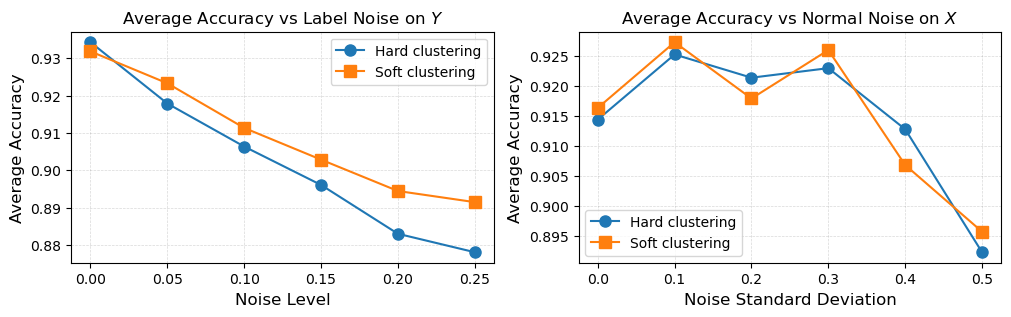

In [106]:
fig, ax = plt.subplots(1,2, figsize=(12,3))

kmeans_means_noise = np.mean(acc_kmeans_noise, axis=1)
kcmeans_means_noise = np.mean(acc_kcmeans_noise, axis=1)

kmeans_means_label_noise = np.mean(acc_kmeans_label_noise, axis=1)
kcmeans_means_label_noise = np.mean(acc_kcmeans_label_noise, axis=1)

# 创建噪声级别数组
noise_levels = np.linspace(0.0, 0.25, 6)

# 绘制点，无线条，添加标记
ax[0].plot(noise_levels, kmeans_means_label_noise, 'o-', label='Hard clustering', markersize=8)  # 'o-' 是圆形标记
ax[0].plot(noise_levels, kcmeans_means_label_noise, 's-', label='Soft clustering', markersize=8)  # 's-' 是方形标记

# 设置图表标题和轴标签
ax[0].set_title('Average Accuracy vs Label Noise on $Y$', fontsize=12)
ax[0].set_xlabel('Noise Level', fontsize=12)
ax[0].set_ylabel('Average Accuracy', fontsize=12)

# 添加图例
ax[0].legend()

noise_std = np.linspace(0.0, 0.5, 6)

# 绘制点，无线条，添加标记
ax[1].plot(noise_std, kmeans_means_noise, 'o-', label='Hard clustering', markersize=8)  # 'o-' 是圆形标记
ax[1].plot(noise_std, kcmeans_means_noise, 's-', label='Soft clustering', markersize=8)  # 's-' 是方形标记

# 设置图表标题和轴标签
ax[1].set_title('Average Accuracy vs Normal Noise on $X$', fontsize=12)
ax[1].set_xlabel('Noise Standard Deviation', fontsize=12)
ax[1].set_ylabel('Average Accuracy', fontsize=12)

# 添加图例
ax[1].legend()

xticks_to_display = noise_levels[::1]  # 这里选择了每隔一个显示
ax[0].set_xticks(xticks_to_display)

xticks_to_display = noise_std[::1]
ax[1].set_xticks(xticks_to_display)
ax[0].grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.3)
ax[1].grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.3)

fig.savefig(f'../image/Zoo_vs_Noise1.pdf', bbox_inches='tight')

# Glass

In [112]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
glass_identification = fetch_ucirepo(id=42) 
  
# data (as pandas dataframes) 
X = glass_identification.data.features.to_numpy() 
y = glass_identification.data.targets.to_numpy().flatten() - 1
y[y>=3]=y[y>=3]-1

In [114]:
compute_pi(y, 6)

array([0.3271028 , 0.35514019, 0.07943925, 0.06074766, 0.04205607,
       0.13551402])

In [92]:
T = 18
m = 1.1
K = 6

L = np.ones((K,K)) - np.eye(K)

n_splits = 5
n_repeats = 20


# 设置交叉验证
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)
acc_kmeans_label_noise = np.zeros((6, n_splits * n_repeats))
acc_kcmeans_label_noise = np.zeros((6, n_splits * n_repeats))
noise_level = 0.0

for i in range(6):
    iteration = 0
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        y_train = add_label_noise(y_train, noise_level=noise_level, num_classes=K)
        
        kmeans = DMC(T=T, discretization='kmeans')
        kmeans.fit(X_train, y_train)
        
        kcmeans = DMC(T=T, m=m, discretization='kcmeans', init=kmeans.cntr)
        kcmeans.fit(X_train, y_train)
    
        y_pred_kmeans = kmeans.predict(X_test, pi=kmeans.piTrain)
        y_pred_kcmeans = kcmeans.predict(X_test, pi=kcmeans.piTrain)
        
        # y_pred_kmeans = kmeans.predict(X_test, pi=kmeans.piStar)
        # y_pred_kcmeans = kcmeans.predict(X_test, pi=kcmeans.piStar)
    
        acc_kmeans_label_noise[i, iteration] = accuracy_score(y_test, y_pred_kmeans)
        acc_kcmeans_label_noise[i, iteration] = accuracy_score(y_test, y_pred_kcmeans)
    
        iteration += 1
    
    noise_level += 0.05

In [93]:
T = 18
m = 1.1
K = 6

L = np.ones((K,K)) - np.eye(K)

std_devs = np.std(X, axis=0)

n_splits = 5
n_repeats = 20
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)

acc_kmeans_noise = np.zeros((6, n_splits * n_repeats))
acc_kcmeans_noise = np.zeros((6, n_splits * n_repeats))

noise_level = 0.0
for i in range(6): 
    iteration = 0
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        noise_levels = noise_level * std_devs
        noise = np.random.normal(0, noise_levels, X_test.shape)
        X_test = X_test + noise
        
        kmeans = DMC(T=T, discretization='kmeans')
        kmeans.fit(X_train, y_train)
        
        kcmeans = DMC(T=T, m=m, discretization='kcmeans', init=kmeans.cntr)
        kcmeans.fit(X_train, y_train)
    
        y_pred_kmeans = kmeans.predict(X_test, pi=kmeans.piTrain)
        y_pred_kcmeans = kcmeans.predict(X_test, pi=kcmeans.piTrain)
    
        acc_kmeans_noise[i, iteration] = accuracy_score(y_test, y_pred_kmeans)
        acc_kcmeans_noise[i, iteration] = accuracy_score(y_test, y_pred_kcmeans)
    
        iteration += 1
    noise_level += 0.1

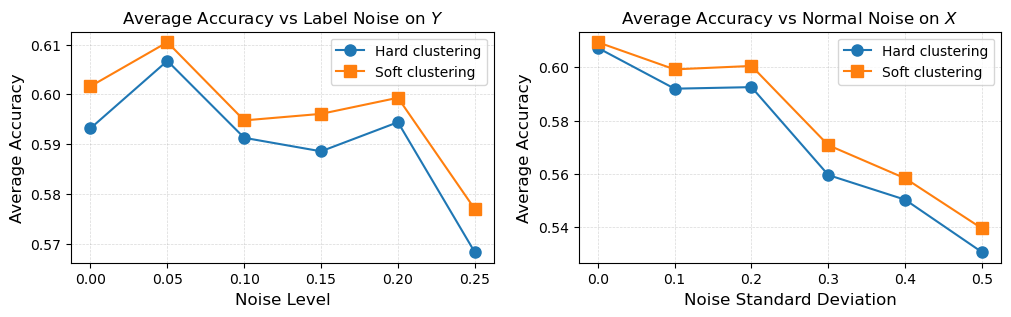

In [94]:
fig, ax = plt.subplots(1,2, figsize=(12,3))

kmeans_means_noise = np.mean(acc_kmeans_noise, axis=1)
kcmeans_means_noise = np.mean(acc_kcmeans_noise, axis=1)

kmeans_means_label_noise = np.mean(acc_kmeans_label_noise, axis=1)
kcmeans_means_label_noise = np.mean(acc_kcmeans_label_noise, axis=1)

# 创建噪声级别数组
noise_levels = np.linspace(0.0, 0.25, 6)

# 绘制点，无线条，添加标记
ax[0].plot(noise_levels, kmeans_means_label_noise, 'o-', label='Hard clustering', markersize=8)  # 'o-' 是圆形标记
ax[0].plot(noise_levels, kcmeans_means_label_noise, 's-', label='Soft clustering', markersize=8)  # 's-' 是方形标记

# 设置图表标题和轴标签
ax[0].set_title('Average Accuracy vs Label Noise on $Y$', fontsize=12)
ax[0].set_xlabel('Noise Level', fontsize=12)
ax[0].set_ylabel('Average Accuracy', fontsize=12)

# 添加图例
ax[0].legend()

noise_std = np.linspace(0.0, 0.5, 6)

# 绘制点，无线条，添加标记
ax[1].plot(noise_std, kmeans_means_noise, 'o-', label='Hard clustering', markersize=8)  # 'o-' 是圆形标记
ax[1].plot(noise_std, kcmeans_means_noise, 's-', label='Soft clustering', markersize=8)  # 's-' 是方形标记

# 设置图表标题和轴标签
ax[1].set_title('Average Accuracy vs Normal Noise on $X$', fontsize=12)
ax[1].set_xlabel('Noise Standard Deviation', fontsize=12)
ax[1].set_ylabel('Average Accuracy', fontsize=12)

# 添加图例
ax[1].legend()

xticks_to_display = noise_levels[::1]  # 这里选择了每隔一个显示
ax[0].set_xticks(xticks_to_display)

xticks_to_display = noise_std[::1]
ax[1].set_xticks(xticks_to_display)
ax[0].grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.3)
ax[1].grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.3)

fig.savefig(f'../image/Glass_vs_Noise1.pdf', bbox_inches='tight')

# Energy

In [61]:
import pandas as pd
from ucimlrepo import fetch_ucirepo 

# Fetch dataset 
dermatology = fetch_ucirepo(id=33) 

# Convert to pandas DataFrame
data = dermatology.data.features
target = dermatology.data.targets

# Check for NaN values in features and remove corresponding rows
data_cleaned = data.dropna()
if isinstance(target, pd.DataFrame):
    target_cleaned = target.loc[data_cleaned.index]
else:
    target_cleaned = target[data_cleaned.index]

# Convert cleaned data back to numpy arrays
X = data_cleaned.to_numpy()
y = target_cleaned.to_numpy().flatten() - 1

In [62]:
X

array([[ 2.,  2.,  0., ...,  1.,  0., 55.],
       [ 3.,  3.,  3., ...,  1.,  0.,  8.],
       [ 2.,  1.,  2., ...,  2.,  3., 26.],
       ...,
       [ 3.,  2.,  2., ...,  2.,  3., 28.],
       [ 2.,  1.,  3., ...,  2.,  3., 50.],
       [ 3.,  2.,  2., ...,  3.,  0., 35.]])

In [63]:
T = 18
m = 1.3
K = 6
L = np.ones((K,K)) - np.eye(K)

n_splits = 5
n_repeats = 20


# 设置交叉验证
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)
acc_kmeans_label_noise = np.zeros((6, n_splits * n_repeats))
acc_kcmeans_label_noise = np.zeros((6, n_splits * n_repeats))
noise_level = 0.0

for i in range(6):
    iteration = 0
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        y_train = add_label_noise(y_train, noise_level=noise_level, num_classes=K)
        
        kmeans = DMC(T=T, discretization='kmeans')
        kmeans.fit(X_train, y_train)
        
        kcmeans = DMC(T=T, m=m, discretization='kcmeans', init=kmeans.cntr)
        kcmeans.fit(X_train, y_train)
    
        y_pred_kmeans = kmeans.predict(X_test, pi=kmeans.piTrain)
        y_pred_kcmeans = kcmeans.predict(X_test, pi=kcmeans.piTrain)
        
        # y_pred_kmeans = kmeans.predict(X_test, pi=kmeans.piStar)
        # y_pred_kcmeans = kcmeans.predict(X_test, pi=kcmeans.piStar)
    
        acc_kmeans_label_noise[i, iteration] = accuracy_score(y_test, y_pred_kmeans)
        acc_kcmeans_label_noise[i, iteration] = accuracy_score(y_test, y_pred_kcmeans)
    
        iteration += 1
    
    noise_level += 0.05

In [64]:
T = 18
m = 1.3

K = 6
L = np.ones((K,K)) - np.eye(K)

std_devs = np.std(X, axis=0)

n_splits = 5
n_repeats = 20
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)

acc_kmeans_noise = np.zeros((6, n_splits * n_repeats))
acc_kcmeans_noise = np.zeros((6, n_splits * n_repeats))

noise_level = 0.0
for i in range(6): 
    iteration = 0
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        noise_levels = noise_level * std_devs
        noise = np.random.normal(0, noise_levels, X_test.shape)
        X_test = X_test + noise
        
        kmeans = DMC(T=T, discretization='kmeans')
        kmeans.fit(X_train, y_train)
        
        kcmeans = DMC(T=T, m=m, discretization='kcmeans', init=kmeans.cntr)
        kcmeans.fit(X_train, y_train)
    
        y_pred_kmeans = kmeans.predict(X_test, pi=kmeans.piTrain)
        y_pred_kcmeans = kcmeans.predict(X_test, pi=kcmeans.piTrain)
    
        acc_kmeans_noise[i, iteration] = accuracy_score(y_test, y_pred_kmeans)
        acc_kcmeans_noise[i, iteration] = accuracy_score(y_test, y_pred_kcmeans)
    
        iteration += 1
    noise_level += 0.1

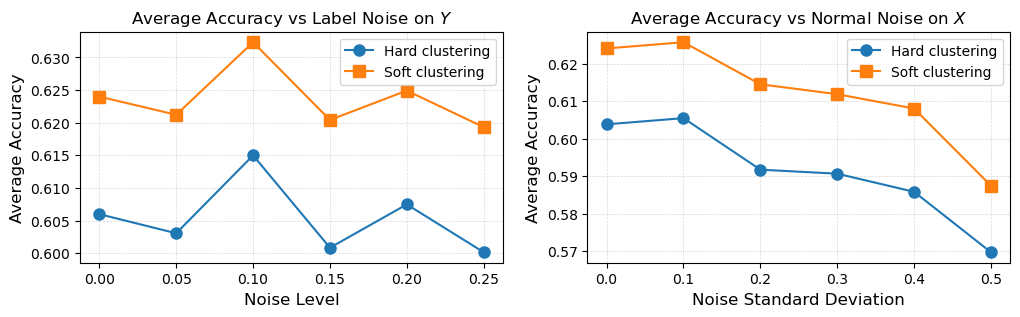

In [65]:
fig, ax = plt.subplots(1,2, figsize=(12,3))

kmeans_means_noise = np.mean(acc_kmeans_noise, axis=1)
kcmeans_means_noise = np.mean(acc_kcmeans_noise, axis=1)

kmeans_means_label_noise = np.mean(acc_kmeans_label_noise, axis=1)
kcmeans_means_label_noise = np.mean(acc_kcmeans_label_noise, axis=1)

# 创建噪声级别数组
noise_levels = np.linspace(0.0, 0.25, 6)

# 绘制点，无线条，添加标记
ax[0].plot(noise_levels, kmeans_means_label_noise, 'o-', label='Hard clustering', markersize=8)  # 'o-' 是圆形标记
ax[0].plot(noise_levels, kcmeans_means_label_noise, 's-', label='Soft clustering', markersize=8)  # 's-' 是方形标记

# 设置图表标题和轴标签
ax[0].set_title('Average Accuracy vs Label Noise on $Y$', fontsize=12)
ax[0].set_xlabel('Noise Level', fontsize=12)
ax[0].set_ylabel('Average Accuracy', fontsize=12)

# 添加图例
ax[0].legend()

noise_std = np.linspace(0.0, 0.5, 6)

# 绘制点，无线条，添加标记
ax[1].plot(noise_std, kmeans_means_noise, 'o-', label='Hard clustering', markersize=8)  # 'o-' 是圆形标记
ax[1].plot(noise_std, kcmeans_means_noise, 's-', label='Soft clustering', markersize=8)  # 's-' 是方形标记

# 设置图表标题和轴标签
ax[1].set_title('Average Accuracy vs Normal Noise on $X$', fontsize=12)
ax[1].set_xlabel('Noise Standard Deviation', fontsize=12)
ax[1].set_ylabel('Average Accuracy', fontsize=12)

# 添加图例
ax[1].legend()

xticks_to_display = noise_levels[::1]  # 这里选择了每隔一个显示
ax[0].set_xticks(xticks_to_display)

xticks_to_display = noise_std[::1]
ax[1].set_xticks(xticks_to_display)
ax[0].grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.3)
ax[1].grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.3)

fig.savefig(f'../image/Energy_vs_Noise.pdf', bbox_inches='tight')

# Single test for IRIS

In [18]:
T = 15
K = 3
L = np.ones((K,K)) - np.eye(K)
iteration = 100

risk_kmeans = np.zeros((3, iteration))
risk_kcmeans = np.zeros((3, iteration))

acc_kmeans = np.zeros(iteration)
acc_kcmeans = np.zeros(iteration)
iris = datasets.load_iris()

X = iris.data
y = iris.target

# X = X + np.random.normal(0, 0.5, X.shape)
# X = X0 
for i in range(iteration):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
    X_test = X_test + np.random.normal(0, 1, X_test.shape)
    kmeans = DMC(T=T, discretization='kmeans')
    kmeans.fit(X_train, y_train)
    
    kcmeans = DMC(T=T, m=1.5, discretization='kcmeans', init=kmeans.cntr)
    kcmeans.fit(X_train, y_train)

    y_pred_kmeans = kmeans.predict(X_test,pi=kmeans.piTrain)
    y_pred_kcmeans = kcmeans.predict(X_test,pi=kcmeans.piTrain)
 
    risk_kmeans[:, i] = compute_conditional_risk(y_test, y_pred_kmeans, K, L)[0]
    risk_kcmeans[:, i] = compute_conditional_risk(y_test, y_pred_kcmeans, K, L)[0]

    acc_kmeans[i] = accuracy_score(y_test, y_pred_kmeans)
    acc_kcmeans[i] = accuracy_score(y_test, y_pred_kcmeans)

{'bodies': [<matplotlib.collections.PolyCollection at 0x19479a80b80>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x19479a80ac0>,
 'cmins': <matplotlib.collections.LineCollection at 0x19479a902b0>,
 'cbars': <matplotlib.collections.LineCollection at 0x19479a90670>}

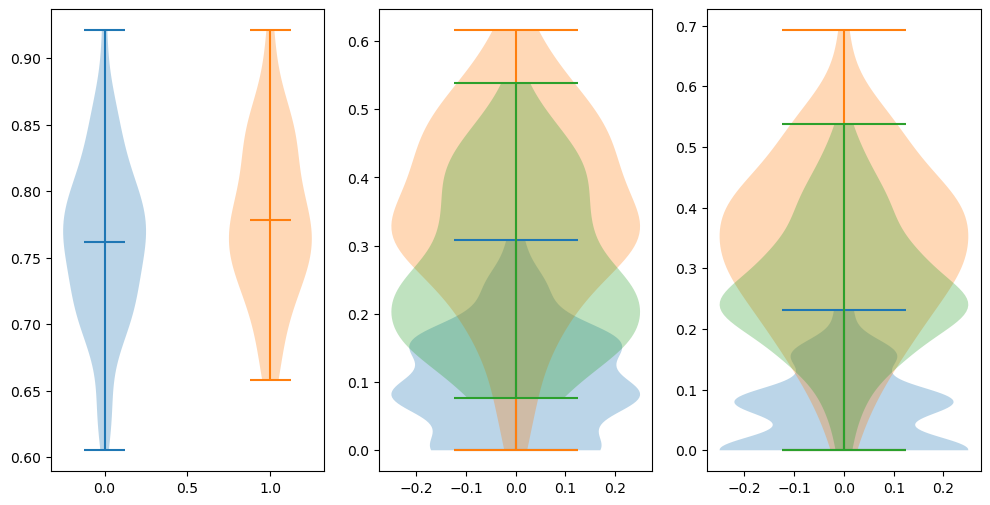

In [19]:
fig, ax = plt.subplots(1,3, figsize=(12,6))

ax[0].violinplot(acc_kmeans, positions=[0], showmeans=True)
ax[0].violinplot(acc_kcmeans, positions=[1], showmeans=True)

ax[1].violinplot(risk_kmeans[0,:], positions=[0])
ax[1].violinplot(risk_kmeans[1,:], positions=[0])
ax[1].violinplot(risk_kmeans[2,:], positions=[0])

ax[2].violinplot(risk_kcmeans[0,:], positions=[0])
ax[2].violinplot(risk_kcmeans[1,:], positions=[0])
ax[2].violinplot(risk_kcmeans[2,:], positions=[0])

# for i in range(2):
#     ax[i+1].set_ylim(0,0.4)

In [117]:
T = 20
K = 2
L = np.ones((K,K)) - np.eye(K)
iteration = 100

risk_kmeans = np.zeros((K, iteration))
risk_kcmeans = np.zeros((K, iteration))

acc_kmeans = np.zeros(iteration)
acc_kcmeans = np.zeros(iteration)

breast_cancer = datasets.load_breast_cancer()

for i in range(iteration):
    X_train, X_test, y_train, y_test = train_test_split(breast_cancer.data, breast_cancer.target, test_size=0.25)
    kmeans = DMC(T=T, discretization='kmeans')
    kmeans.fit(X_train, y_train)
    
    kcmeans = DMC(T=T, m=1.5, discretization='kcmeans', init=kmeans.cntr)
    kcmeans.fit(X_train, y_train)

    y_pred_kmeans = kmeans.predict(X_test, pi=kmeans.piStar)
    y_pred_kcmeans = kcmeans.predict(X_test, pi=kcmeans.piStar)
 
    risk_kmeans[:, i] = compute_conditional_risk(y_test, y_pred_kmeans, K, L)[0]
    risk_kcmeans[:, i] = compute_conditional_risk(y_test, y_pred_kcmeans, K, L)[0]

    acc_kmeans[i] = accuracy_score(y_test, y_pred_kmeans)
    acc_kcmeans[i] = accuracy_score(y_test, y_pred_kcmeans)

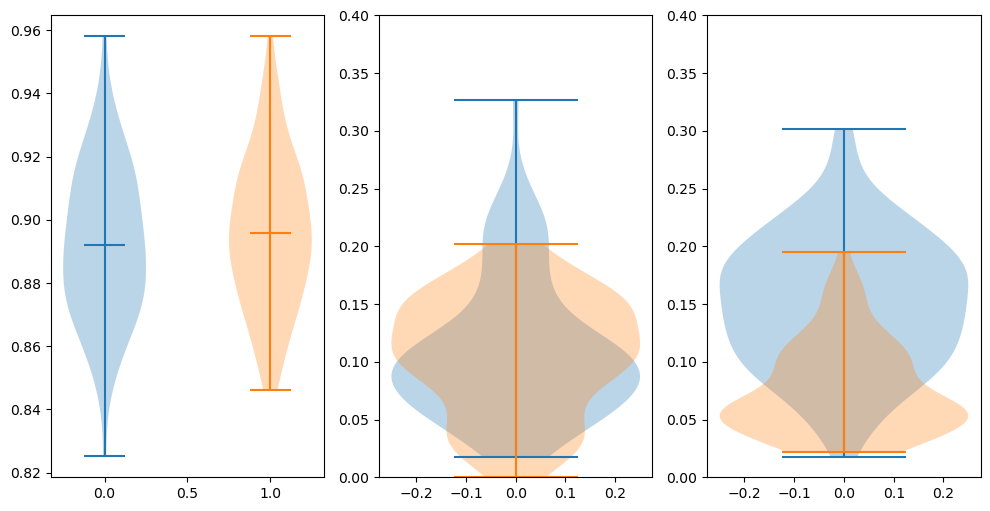

In [118]:
fig, ax = plt.subplots(1,3, figsize=(12,6))

ax[0].violinplot(acc_kmeans, positions=[0], showmeans=True)
ax[0].violinplot(acc_kcmeans, positions=[1], showmeans=True)

ax[1].violinplot(risk_kmeans[0,:], positions=[0])
ax[1].violinplot(risk_kmeans[1,:], positions=[0])

ax[2].violinplot(risk_kcmeans[0,:], positions=[0])
ax[2].violinplot(risk_kcmeans[1,:], positions=[0])

for i in range(2):
    ax[i+1].set_ylim(0,0.4)

In [102]:
T = 10
K = 2
L = np.ones((K,K)) - np.eye(K)

# 创建数据集
X, y = datasets.make_blobs(n_samples=[125 * 5, 125 * 5], n_features=2, centers=[(9.5, 10), (10, 9.4)],
                  cluster_std=[[0.6, 0.6], [0.6, 0.6]], shuffle=True, random_state=42)

n_splits=5
n_repeats=20

# 设置交叉验证
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)
acc_kmeans = np.zeros((5, n_splits * n_repeats))
acc_kcmeans = np.zeros((5, n_splits * n_repeats))
noise_level = 0.0

for i in range(5):
    # risk_kmeans = np.zeros((2, 100))
    # risk_kcmeans = np.zeros((2, 100))
    
    iteration = 0
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        y_train = add_label_noise(y_train, noise_level=noise_level, num_classes=2)
        
        kmeans = DMC(T=T, discretization='kmeans')
        kmeans.fit(X_train, y_train)
        
        kcmeans = DMC(T=T, m=1.5, discretization='kcmeans', init=kmeans.cntr, N=1)
        kcmeans.fit(X_train, y_train)
    
        y_pred_kmeans = kmeans.predict(X_test)
        y_pred_kcmeans = kcmeans.predict(X_test)
     
        # risk_kmeans[:, iteration] = compute_conditional_risk(y_test, y_pred_kmeans, K, L)[0]
        # risk_kcmeans[:, iteration] = compute_conditional_risk(y_test, y_pred_kcmeans, K, L)[0]
    
        acc_kmeans[i, iteration] = accuracy_score(y_test, y_pred_kmeans)
        acc_kcmeans[i, iteration] = accuracy_score(y_test, y_pred_kcmeans)
    
        iteration += 1
    
    noise_level += 0.1

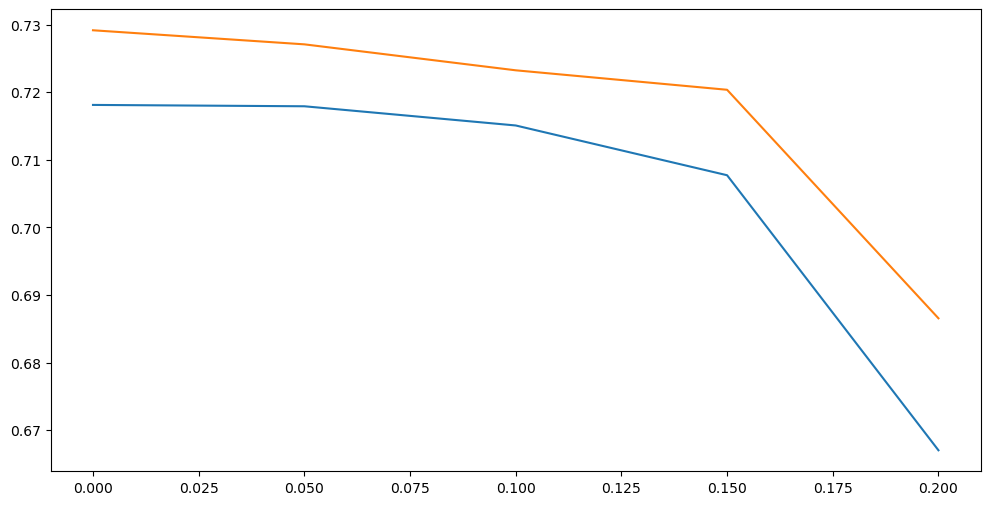

In [103]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(np.linspace(0.0, 0.2, 5), np.mean(acc_kmeans, axis=1))
ax.plot(np.linspace(0.0, 0.2, 5), np.mean(acc_kcmeans, axis=1))


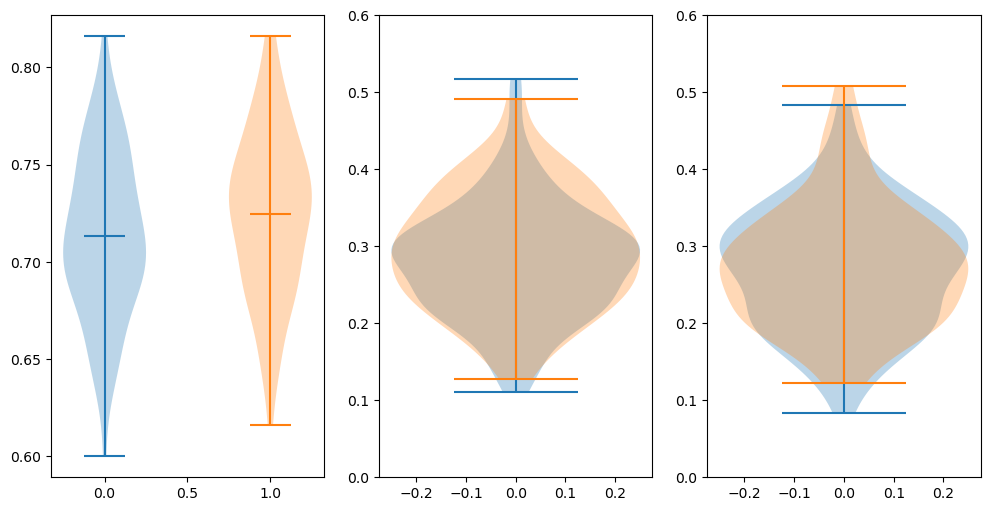

In [68]:
fig, ax = plt.subplots(1,3, figsize=(12,6))

ax[0].violinplot(acc_kmeans, positions=[0], showmeans=True)
ax[0].violinplot(acc_kcmeans, positions=[1], showmeans=True)

ax[1].violinplot(risk_kmeans[0,:], positions=[0])
ax[1].violinplot(risk_kmeans[1,:], positions=[0])

ax[2].violinplot(risk_kcmeans[0,:], positions=[0])
ax[2].violinplot(risk_kcmeans[1,:], positions=[0])

for i in range(2):
    ax[i+1].set_ylim(0,0.6)

In [64]:
from scipy import stats
t_stat, p_value = stats.ttest_ind(acc_kmeans, acc_kcmeans)

print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -2.562491408121134
P-value: 0.011135389794910099


In [145]:
T = 8
noise_std = 1
K = 2
L = np.ones((K,K)) - np.eye(K)
iteration = 100

risk_kmeans = np.zeros((2, iteration))
risk_kcmeans = np.zeros((2, iteration))

acc_kmeans = np.zeros(iteration)
acc_kcmeans = np.zeros(iteration)

for i in range(iteration):
    X_train, y_train = datasets.make_blobs(n_samples=[125 * 5, 125 * 5], n_features=2, centers=[(9.5, 10), (9.5, 9.4)],
                                           cluster_std=[[0.6, 0.6], [0.6, 0.6]], shuffle=True, random_state=None)
    # X_test, y_test = datasets.make_blobs(n_samples=[125 * 5, 125 * 2], n_features=2, centers=[(11, 9.5), (9.3, 9.9)],
    #                                        cluster_std=[[0.6, 0.6], [0.35, 0.3]], shuffle=True, random_state=None)
    X_test, y_test = datasets.make_blobs(n_samples=[125 * 5, 125 * 5], n_features=2, centers=[(9.5, 10), (9.5, 9.4)],
                                           cluster_std=[[0.6, 0.6], [0.3, 0.3]], shuffle=True, random_state=None)
    kmeans = DMC(T=T, discretization='kmeans')
    kmeans.fit(X_train, y_train)
    
    kcmeans = DMC(T=T, m=1.6, discretization='kcmeans', init=kmeans.cntr)
    kcmeans.fit(X_train, y_train)
 
    y_pred_kmeans = kmeans.predict(X_test)
    y_pred_kcmeans = kcmeans.predict(X_test)
    
    risk_kmeans[:, i] = compute_conditional_risk(y_test, y_pred_kmeans, K, L)[0]
    risk_kcmeans[:, i] = compute_conditional_risk(y_test, y_pred_kcmeans, K, L)[0]

    acc_kmeans[i] = accuracy_score(y_test, y_pred_kmeans)
    acc_kcmeans[i] = accuracy_score(y_test, y_pred_kcmeans)


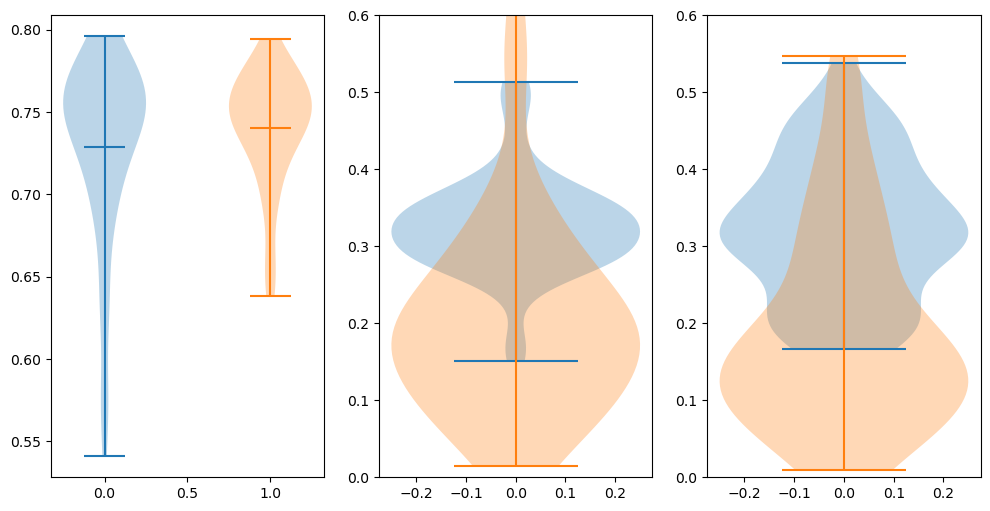

In [146]:
fig, ax = plt.subplots(1,3, figsize=(12,6))

ax[0].violinplot(acc_kmeans, positions=[0], showmeans=True)
ax[0].violinplot(acc_kcmeans, positions=[1], showmeans=True)

ax[1].violinplot(risk_kmeans[0,:], positions=[0])
ax[1].violinplot(risk_kmeans[1,:], positions=[0])

ax[2].violinplot(risk_kcmeans[0,:], positions=[0])
ax[2].violinplot(risk_kcmeans[1,:], positions=[0])

for i in range(2):
    ax[i+1].set_ylim(0,0.6)